<a href="https://colab.research.google.com/github/BhavyaJohar/Learning-Quant/blob/main/BTCUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
df = pd.read_csv(
    "btcusd_1-min_data.csv",
    dtype={
      "Timestamp": float,
      "Open": "float32",
      "High": "float32",
      "Low": "float32",
      "Close": "float32",
      "Volume": "float32"
    }
)

In [40]:
df["datetime"] = pd.to_datetime(df["Timestamp"], unit="s")
df.set_index("datetime", inplace=True)
df.drop(columns="Timestamp", inplace=True)

In [41]:
df.sort_index(inplace=True)
print(df.index.is_monotonic_increasing)

True


## Handling Missing & Irregular Data

In [42]:
# Are there any exact duplicate timestamps?
dupes = df.index.duplicated().sum()
print(f"Duplicate timestamps: {dupes}")

# Count gaps in the 1‑minute sequence
full_idx = pd.date_range(df.index.min(), df.index.max(), freq='min')
missing = full_idx.difference(df.index)
print(f"Missing minutes: {len(missing)}")

Duplicate timestamps: 0
Missing minutes: 1160


In [43]:
# 1. Get a sorted list of all missing timestamps
missing = pd.DatetimeIndex(full_idx.difference(df.index))

# 2. Compute the difference between consecutive missing times
delta = missing.to_series().diff().dt.seconds.fillna(60)

# 3. Every time delta != 60s, a new gap block starts
block_id = (delta != 60).cumsum()

# 4. Summarize each block’s size
gap_summary = (
    missing.to_series()
           .groupby(block_id)
           .agg(start_time=lambda s: s.min(),
                end_time=lambda s: s.max(),
                minutes=lambda s: len(s))
           .reset_index(drop=True)
)
print(gap_summary.head(10))

           start_time            end_time  minutes
0 2025-03-15 00:01:00 2025-03-15 19:20:00     1160


In [44]:
mask = ~((df.index >= '2025-03-15 00:01') & (df.index <= '2025-03-15 19:20'))
filtered = df.loc[mask]

# now reindex and interpolate only the remaining small gaps
full_idx  = pd.date_range(filtered.index.min(), filtered.index.max(), freq='min')
reindexed = filtered.reindex(full_idx)

# fill in only the short gaps
price_cols = ['Open','High','Low','Close']
reindexed[price_cols] = reindexed[price_cols].interpolate(method='time')
reindexed['Volume'] = reindexed['Volume'].fillna(0)
cleaned = reindexed

In [45]:
cleaned.isna().sum()  # Should be zero/minimal

,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [46]:
# Define the date ranges for train and test sets
train_start_date = '2023-03-14'
train_end_date = '2025-03-14'
test_start_date = '2025-03-16'
test_end_date = '2025-05-04'

# Create train and test sets
train_data = cleaned[(cleaned.index >= train_start_date) & (cleaned.index <= train_end_date)]
test_data = cleaned[(cleaned.index >= test_start_date) & (cleaned.index <= test_end_date)]

# Print the shapes of the train and test sets to verify
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1052641, 5)
Test data shape: (70561, 5)


# Trendline Automation

In [47]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices,
    # return negative val if invalid

    # Find the intercept of the line going through pivot point with given slope
    intercept = -slope * pivot + y[pivot]
    line_vals = slope * np.arange(len(y)) + intercept

    diffs = line_vals - y

    # Check to see if the line is valid, return -1 if it is not valid.
    if support and diffs.max() > 1e-5:
        return -1.0
    elif not support and diffs.min() < -1e-5:
        return -1.0

    # Squared sum of diffs between data and line
    err = (diffs ** 2.0).sum()
    return err;


def optimize_slope(support: bool, pivot:int , init_slope: float, y: np.array):
    # Amount to change slope by. Multiplyed by opt_step
    slope_unit = (y.max() - y.min()) / len(y)

    # Optmization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step # current step

    # Initiate at the slope of the line of best fit
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    assert(best_err >= 0.0) # Shouldn't ever fail with initial slope

    get_derivative = True
    derivative = None
    while curr_step > min_step:

        if get_derivative:
            # Numerical differentiation, increase slope by very small amount
            # to see if error increases/decreases.
            # Gives us the direction to change slope.
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err;

            # If increasing by a small amount fails,
            # try decreasing by a small amount
            if test_err < 0.0:
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0: # Derivative failed, give up
                raise Exception("Derivative failed. Check  data. ")

            get_derivative = False

        if derivative > 0.0: # Increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else: # Increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step


        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err:
            # slope failed/didn't reduce error
            curr_step *= 0.5 # Reduce step size
        else: # test slope reduced error
            best_err = test_err
            best_slope = test_slope
            get_derivative = True # Recompute derivative

    # Optimize done, return best slope and intercept
    return (best_slope, -best_slope * pivot + y[pivot])

def fit_upper_trendline(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (data - line_points).argmax()
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)
    return resist_coefs

def fit_lower_trendline(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)
    line_points = coefs[0] * x + coefs[1]
    lower_pivot = (data - line_points).argmin()
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    return support_coefs

def fit_trendlines_single(data: np.array):
    # find line of best fit (least squared)
    # coefs[0] = slope,  coefs[1] = intercept
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get points of line.
    line_points = coefs[0] * x + coefs[1]

    # Find upper and lower pivot points
    upper_pivot = (data - line_points).argmax()
    lower_pivot = (data - line_points).argmin()

    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs)

def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)
    # coefs[0] = slope,  coefs[1] = intercept
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (high - line_points).argmax()
    lower_pivot = (low - line_points).argmin()

    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)

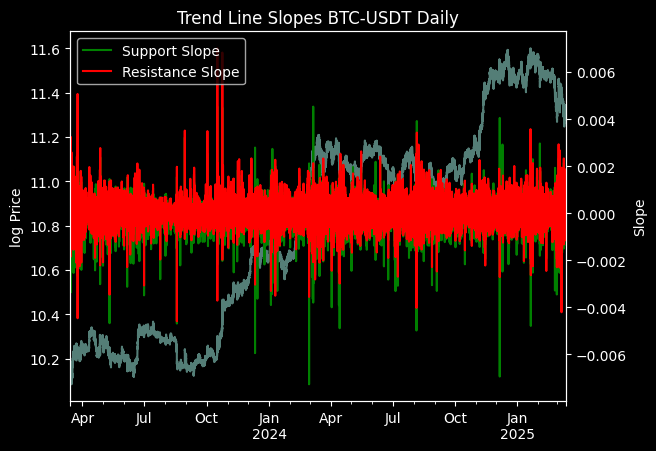

In [48]:
# make a copy so we don’t clobber train_data
data = train_data.copy()

# only apply log to the price columns
price_cols = ["Open","High","Low","Close"]
data[price_cols] = np.log(data[price_cols])

# Trendline parameter
lookback = 15
n = len(data)

support_slope = np.full(n, np.nan)
resist_slope  = np.full(n, np.nan)

for i in range(lookback - 1, n):
    window = data.iloc[i - lookback + 1 : i + 1]

    high_vals  = window['High'].values
    low_vals   = window['Low'].values
    close_vals = window['Close'].values

    (sup_m, _), (res_m, _) = fit_trendlines_high_low(high_vals, low_vals, close_vals)
    support_slope[i] = sup_m
    resist_slope[i]  = res_m

data['support_slope'] = support_slope
data['resist_slope']  = resist_slope

plt.style.use('dark_background')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

data['Close'].plot(ax=ax1, alpha=0.6)
data['support_slope'].plot(ax=ax2, label='Support Slope', color='green')
data['resist_slope'].plot(ax=ax2, label='Resistance Slope', color='red')

ax1.set_title("Trend Line Slopes BTC-USDT Daily")
ax1.set_ylabel("log Price")
ax2.set_ylabel("Slope")
ax2.legend(loc='upper left')
plt.show()

In [52]:
data.tail()

,Open,High,Low,Close,Volume,support_slope,resist_slope
2025-03-13 23:56:00,11.303426,11.303685,11.303426,11.303685,0.001245,0.000017,0.000083
2025-03-13 23:57:00,11.303290,11.303365,11.303118,11.303118,0.003001,0.000017,0.000029
2025-03-13 23:58:00,11.302933,11.303006,11.302933,11.303006,0.001316,0.000010,-0.000022
2025-03-13 23:59:00,11.302821,11.303180,11.302821,11.303180,0.004921,-0.000009,-0.000056
2025-03-14 00:00:00,11.303241,11.303241,11.302970,11.302970,0.005216,-0.000014,-0.000094


# Trendline Breakout

In [49]:
pip install pandas-ta mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.5 MB/s eta 0:00:00
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=7361501460b99fa09d5530b5f56e1eb9bf230d6bd76181e76ebb9fb493850879
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta


In [50]:
def trendline_breakout(close: np.array, lookback:int):
    s_tl = np.zeros(len(close))
    s_tl[:] = np.nan

    r_tl = np.zeros(len(close))
    r_tl[:] = np.nan

    sig = np.zeros(len(close))

    for i in range(lookback, len(close)):
        # NOTE window does NOT include the current candle
        window = close[i - lookback: i]

        s_coefs, r_coefs = fit_trendlines_single(window)

        # Find current value of line, projected forward to current bar
        s_val = s_coefs[1] + lookback * s_coefs[0]
        r_val = r_coefs[1] + lookback * r_coefs[0]

        s_tl[i] = s_val
        r_tl[i] = r_val

        if close[i] > r_val:
            sig[i] = 1.0
        elif close[i] < s_val:
            sig[i] = -1.0
        else:
            sig[i] = sig[i - 1]

    return s_tl, r_tl, sig

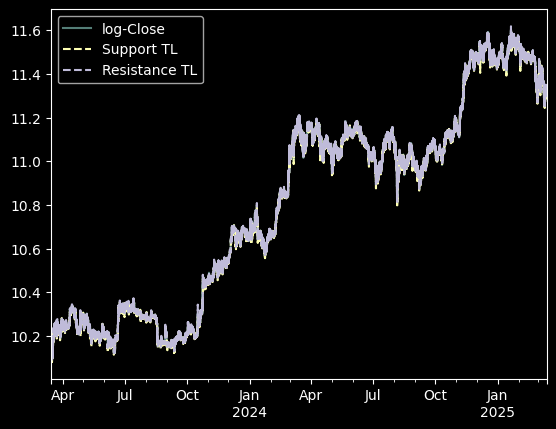

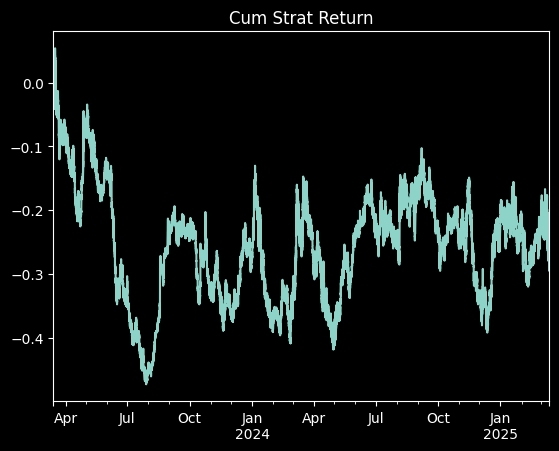

In [54]:
# 1) Run the breakout function on  log‑price array
lookback = 15
close_arr = data['Close'].to_numpy()
s_tl, r_tl, sig_raw = trendline_breakout(close_arr, lookback)

# 2) Attach the results back to  DataFrame
data['sup_line_val'] = s_tl
data['res_line_val'] = r_tl
data['sig_raw'] = sig_raw

# 3) (Optional) Plot price vs. the projected trendlines
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
data['Close'].plot(ax=ax, alpha=0.6, label='log‑Close')
data['sup_line_val'].plot(ax=ax, linestyle='--', label='Support TL')
data['res_line_val'].plot(ax=ax, linestyle='--', label='Resistance TL')
ax.legend(); plt.show()

# 4) Refine  signals by filtering on slope direction
#    • Only go long on breakouts when resistance is trending up
#    • Only go short on breakdowns when support is trending down
data['sig_filt'] = 0
long_idx = (data['sig_raw'] == 1)  & (data['resist_slope'] >  0)
short_idx = (data['sig_raw'] == -1) & (data['support_slope'] <  0)
data.loc[long_idx,  'sig_filt'] = 1
data.loc[short_idx, 'sig_filt'] = -1

# 5) Backtest or feature‑engineering
#    e.g., compute 1‑bar ahead log‑return and multiply by sig_filt
data['mkt_ret']  = data['Close'].diff().shift(-1)
data['strat_ret'] = data['sig_filt'] * data['mkt_ret']
data['strat_ret'].cumsum().plot(title="Cum Strat Return"); plt.show()

In [57]:
data.tail(20)

,Open,High,Low,Close,Volume,support_slope,resist_slope,sup_line_val,res_line_val,sig_raw,sig_filt,mkt_ret,strat_ret
2025-03-13 23:41:00,11.303019,11.303451,11.303019,11.303019,0.402373,0.000006,-0.000004,11.302938,11.304299,-1.0,0,-0.000197,-0.000000
2025-03-13 23:42:00,11.302797,11.302858,11.302760,11.302821,1.862369,-0.000013,-0.000043,11.302928,11.304176,-1.0,-1,0.000087,-0.000087
2025-03-13 23:43:00,11.302846,11.302908,11.302846,11.302908,0.066061,-0.000013,-0.000081,11.302814,11.303846,-1.0,-1,-0.000099,0.000099
2025-03-13 23:44:00,11.302821,11.302821,11.302797,11.302809,1.481029,-0.000013,-0.000124,11.302797,11.303463,-1.0,-1,0.000149,-0.000149
2025-03-13 23:45:00,11.302958,11.302958,11.302958,11.302958,0.000100,-0.000069,-0.000129,11.302685,11.302903,1.0,0,0.000530,0.000000
2025-03-13 23:46:00,11.303278,11.303488,11.303019,11.303488,0.077418,-0.000060,-0.000067,11.302345,11.302818,1.0,0,0.000050,0.000000
2025-03-13 23:47:00,11.303611,11.303611,11.303278,11.303537,0.158618,-0.000047,-0.000052,11.302465,11.303420,1.0,0,0.000123,0.000000
2025-03-13 23:48:00,11.303660,11.303660,11.303660,11.303660,0.029230,-0.000047,-0.000044,11.302642,11.303480,1.0,0,0.000000,0.000000
2025-03-13 23:49:00,11.303660,11.303660,11.303648,11.303660,0.096904,-0.000023,-0.000042,11.302610,11.303617,1.0,0,0.000518,0.000000
2025-03-13 23:50:00,11.303968,11.304178,11.303968,11.304178,0.004875,0.000014,0.000011,11.302642,11.303608,1.0,1,-0.000222,-0.000222


# Strategy is Terrible 😢

### Let's see if a little ML can make it better!

In [58]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fc23dca8d175889dd58dbb59c417d4a042b17529e62da9799beece72297900c5
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [60]:
import ta

def trendline_breakout_dataset(
        ohlcv: pd.DataFrame,
        lookback: int,
        hold_period: int = 12,
        tp_mult: float  = 3.0,
        sl_mult: float  = 3.0,
        atr_lookback: int = 168
):
    print(atr_lookback >= lookback, "ATR window must be >= trendline lookback")

    # 1) build log‑price array
    close = np.log(ohlcv['Close'].to_numpy())

    # 2) compute ATR over log‑prices
    atr_calc = ta.volatility.AverageTrueRange(
        high=ohlcv['High'], low=ohlcv['Low'], close=ohlcv['Close'], window=atr_lookback
    )
    atr_arr = atr_calc.average_true_range().to_numpy()

    # 3) normalize volume by its rolling median
    vol_arr = (ohlcv['Volume'] / ohlcv['Volume']
               .rolling(window=atr_lookback)
               .median()
              ).to_numpy()

    # 4) get ADX over the trendline window
    adx_calc = ta.trend.ADXIndicator(
        high=ohlcv['High'], low=ohlcv['Low'], close=ohlcv['Close'], window=lookback
    )
    adx_arr = adx_calc.adx().to_numpy()

    trades = pd.DataFrame()
    trade_i = 0
    in_trade = False

    for i in range(atr_lookback, len(ohlcv)):
        window = close[i - lookback : i]
        s_coefs, r_coefs = fit_trendlines_single(window)
        r_val = r_coefs[1] + lookback * r_coefs[0]

        # ENTRY: breakout above resistance
        if not in_trade and close[i] > r_val:
            entry_p = close[i]
            atr_i    = atr_arr[i]
            tp_price = entry_p + tp_mult * atr_i
            sl_price = entry_p - sl_mult * atr_i
            hp_i     = i + hold_period
            in_trade = True

            trades.loc[trade_i, ['entry_i','entry_p','atr','tp','sl','hp_i']] = [
                i, entry_p, atr_i, tp_price, sl_price, hp_i
            ]
            trades.loc[trade_i, ['slope','intercept']] = r_coefs
            # features
            trades.loc[trade_i, 'resist_s'] = r_coefs[0] / atr_i
            line_vals = r_coefs[1] + np.arange(lookback)*r_coefs[0]
            trades.loc[trade_i, 'tl_err']    = (line_vals - window).mean() / atr_i
            trades.loc[trade_i, 'max_dist']  = (line_vals - window).max()  / atr_i
            trades.loc[trade_i, 'vol']       = vol_arr[i]
            trades.loc[trade_i, 'adx']       = adx_arr[i]

        # EXIT: TP, SL, or max hold
        if in_trade:
            if close[i] >= trades.loc[trade_i, 'tp'] \
            or close[i] <= trades.loc[trade_i, 'sl'] \
            or i >= trades.loc[trade_i, 'hp_i']:
                trades.loc[trade_i, ['exit_i','exit_p']] = [i, close[i]]
                in_trade = False
                trade_i += 1

    # compute per‑trade returns
    trades['return'] = trades['exit_p'] - trades['entry_p']

    # assemble ML dataset
    data_x = trades[['resist_s','tl_err','vol','max_dist','adx']].copy()
    data_y = (trades['return'] > 0).astype(int)

    return trades, data_x, data_y

In [62]:
# make sure `data` has columns Open,High,Low,Close,Volume
trades, X, y = trendline_breakout_dataset(
    ohlcv = data,
    lookback      = 15,    #  trendline window in minutes
    hold_period   = 60,    # e.g. hold at most 60 minutes
    tp_mult       = 3.0,   # take‑profit = 3 × ATR
    sl_mult       = 3.0,   # stop‑loss   = 3 × ATR
    atr_lookback  = 168    # ATR over 168 minutes (~2.8 hours)
)

# drop any incomplete trades
trades = trades.dropna()

# peek at  new trades table
print(trades.head())
# X holds  per‑trade features, y the 0/1 profitability labels
print(X.head(), y.head())

True ATR window must be >= trendline lookback
  entry_i   entry_p       atr        tp        sl hp_i     slope  intercept  \
0     174  2.312201  0.000969  2.315108  2.309294  234 -0.000016   2.312400   
1     238  2.311956  0.001029  2.315043  2.308869  298  0.000008   2.311813   
2     305  2.312213  0.001117  2.315566  2.308861  365 -0.000036   2.312667   
3     374  2.312905  0.001199  2.316501  2.309309  434 -0.000054   2.313610   
4     435  2.312621  0.001028  2.315704  2.309537  495 -0.000002   2.312640   

   resist_s    tl_err  max_dist        vol        adx  exit_i    exit_p  \
0 -0.016193  0.115363  0.238840   7.453501  18.661775   234.0  2.311743   
1  0.007643  0.088077  0.167980  19.374913  17.347508   298.0  2.312218   
2 -0.032259  0.104678  0.300764   0.173774  17.209336   365.0  2.313188   
3 -0.044901  0.134185  0.362548   0.429941  21.313173   434.0  2.312629   
4 -0.001486  0.043831  0.124131   0.011536  21.952066   495.0  2.313107   

     return  
0 -0.000458  


In [63]:
# Save CSV
trades.to_csv("trades.csv", index=False)
X.to_csv("features.csv", index=False)
y.to_csv("labels.csv", index=False)

# Machine Learning Time

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
def walkforward_model(
        close: np.array, trades:pd.DataFrame,
        data_x: pd.DataFrame, data_y: pd.Series,
        train_size: int, step_size: int
):

    signal = np.zeros(len(close))
    prob_signal = np.zeros(len(close))

    next_train = train_size
    trade_i = 0

    in_trade = False
    tp_price = None
    sl_price = None
    hp_i = None


    model = None
    for i in range( len(close)):
        if i == next_train:
            start_i = i - train_size

            train_indices = trades[(trades['entry_i'] > start_i) & (trades['exit_i'] < i)].index

            x_train = data_x.loc[train_indices]
            y_train = data_y.loc[train_indices]
            print('training', i, 'N cases', len(train_indices))
            model = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=69420)
            model.fit(x_train.to_numpy(), y_train.to_numpy())

            next_train += step_size

        if in_trade:
            if close[i] >= tp_price or close[i] <= sl_price or i >= hp_i:
                signal[i] = 0
                prob_signal[i] = 0
                in_trade = False
            else:
                signal[i] = signal[i - 1]
                prob_signal[i] = prob_signal[i - 1]


        if  trade_i < len(trades) and i == trades['entry_i'].iloc[trade_i]:

            if model is not None:
                prob = model.predict_proba(data_x.iloc[trade_i].to_numpy().reshape(1, -1))[0][1]
                prob_signal[i] = prob

                trades.loc[trade_i, 'model_prob'] = prob

                if prob > 0.5: # greater than 50%, take trade
                    signal[i] = 1

                in_trade = True
                trade = trades.iloc[trade_i]
                tp_price = trade['tp']
                sl_price = trade['sl']
                hp_i = trade['hp_i']

            trade_i += 1

    return signal, prob_signal

True ATR window must be >= trendline lookback
training 1052641 N cases 16162
OOS Profit Factor: 1.4934323243860652
OOS Win Rate: 0.6923076923076923


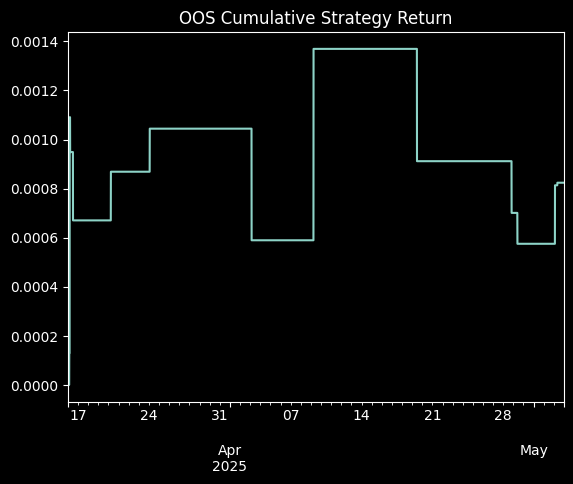

In [68]:
# --- Load 2‑year train artifacts ---
# load
trades_train = pd.read_csv("trades.csv")
X_train = pd.read_csv("features.csv")
y_train = pd.read_csv("labels.csv").iloc[:,0]

# build a boolean mask of the “bad” rows in X_train
mask = X_train.replace([np.inf, -np.inf], np.nan) \
              .isna() \
              .any(axis=1) \
              .to_numpy()   # this is an ndarray of length len(X_train)

# apply to X_train and y_train (lengths match here)
X_train = X_train.iloc[~mask].reset_index(drop=True)
y_train = y_train.iloc[~mask].reset_index(drop=True)

# apply to trades_train by slicing the mask down to its length
n_tr = len(trades_train)
mask_trades = mask[:n_tr] # chop it to exactly len(trades_train)
trades_train = trades_train.iloc[~mask_trades].reset_index(drop=True)

# --- Build trades/features/labels for 2‑month OOS DataFrame ---
trades_oos, X_oos, y_oos = trendline_breakout_dataset(
    ohlcv        = test_data,
    lookback     = 15,
    hold_period  = 60,
    tp_mult      = 3.0,
    sl_mult      = 3.0,
    atr_lookback = 168
)

# --- Clean infinities/NaNs from OOS features ---
mask_oos = X_oos.replace([np.inf, -np.inf], np.nan).isna().any(axis=1)
X_oos = X_oos[~mask_oos].reset_index(drop=True)
y_oos = y_oos[~mask_oos].reset_index(drop=True)
trades_oos = trades_oos[~mask_oos].reset_index(drop=True)

# --- Compute how many bars were in original train_data ---
n_train_bars = train_data.shape[0]

# --- Offset the OOS trade entry/exit indices to continue past train_data ---
trades_oos["entry_i"] += n_train_bars
trades_oos["exit_i"]  += n_train_bars

# --- Concatenate train + OOS tables into “full” versions ---
trades_full = pd.concat([trades_train, trades_oos], ignore_index=True)
X_full = pd.concat([X_train, X_oos], ignore_index=True)
y_full = pd.concat([y_train, y_oos], ignore_index=True)

# --- Build  single, continuous close‑array (log prices) ---
full_bars = pd.concat([train_data, test_data], axis=0)
close_arr = np.log(full_bars["Close"].to_numpy())

# --- Run the walk‑forward meta‑model (one retrain at the split) ---
signal, prob_signal = walkforward_model(
    close = close_arr,
    trades = trades_full,
    data_x = X_full,
    data_y = y_full,
    train_size = n_train_bars,
    step_size = test_data.shape[0]
)

# --- Attach the OOS portion of the signals back to test_data DF ---
test_data = test_data.copy()
test_data["signal"] = signal[n_train_bars:]
test_data["prob"] = prob_signal[n_train_bars:]

test_data["r"] = np.log(test_data["Close"]).diff().shift(-1)
test_data["strat_ret"] = test_data["signal"] * test_data["r"]

# Profit Factor
pf = test_data.loc[test_data["signal"] == 1, "strat_ret"] \
            .pipe(lambda s: s[s>0].sum() / s[s<0].abs().sum())
print("OOS Profit Factor:", pf)

# Win Rate
#    (this is O(n_trades), negligible)
probs = test_data["prob"].reset_index(drop=True)  # Series of length = len(test_data)

# compute the 0‑based offset into the OOS slice for each entry
oos_offsets = trades_oos["entry_i"].astype(int) - n_train_bars

# grab the probability at the exact entry bar
trades_oos["model_prob"] = probs.iloc[oos_offsets].values

# 3) Now you can compute  metrics immediately:
taken = trades_oos[trades_oos["model_prob"] > 0.5]

# Win Rate
win_rate = (taken["return"] > 0).mean()
print("OOS Win Rate:", win_rate)

# Cumulative PnL plot
plt.style.use("dark_background")
test_data["strat_ret"].cumsum().plot(title="OOS Cumulative Strategy Return")
plt.show()

In [73]:
trades_oos.tail()

,entry_i,entry_p,atr,tp,sl,hp_i,slope,intercept,resist_s,tl_err,max_dist,vol,adx,exit_i,exit_p,return,model_prob
1060,1122949,11.475805,16.891567,62.150506,-39.198896,70368,-9.069953e-07,11.475776,-5.369516e-08,0.000008,0.000028,0.084685,25.039298,1123009.0,11.475691,-0.000114,0.484277
1061,1123010,11.476116,16.395984,60.664068,-37.711835,70429,4.038334e-05,11.475504,2.463002e-06,0.000017,0.000033,17.202616,27.975608,1123070.0,11.474788,-0.001328,0.495084
1062,1123071,11.475203,17.283315,63.325147,-40.374742,70490,-7.146550e-05,11.475992,-4.134942e-06,0.000021,0.000043,1.109214,26.647950,1123131.0,11.474372,-0.000831,0.476692
1063,1123137,11.474205,19.555841,70.141727,-47.193317,70556,-7.496167e-05,11.475276,-3.833211e-06,0.000011,0.000026,0.346833,15.342257,1123197.0,11.470999,-0.003206,0.480378
1064,1123198,11.470967,22.475191,78.896539,-55.954605,70617,-7.682801e-05,11.472120,-3.418347e-06,0.000014,0.000033,0.001671,30.062099,NaN,NaN,NaN,0.483860


Observed PF = 1.9625, WR = 69.23%
PF p‑value: 0.2422
WR p‑value: 0.1302


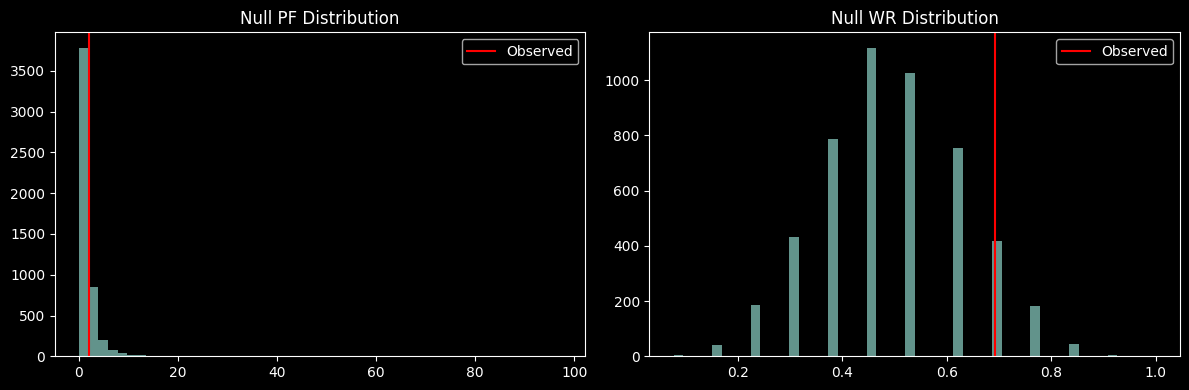

In [77]:
# Drop incomplete trades, coerce returns to float
trades_oos = trades_oos.dropna(subset=['return','model_prob']).copy()
trades_oos['return'] = trades_oos['return'].astype(float)

# Build the binary prediction column
trades_oos['pred'] = (trades_oos['model_prob'] > 0.5).astype(int)

# Pull out numpy arrays of returns & preds
rets  = trades_oos['return'].to_numpy(dtype=float)
preds = trades_oos['pred'].to_numpy(dtype=int)

# Observed metrics on taken trades
mask_taken = preds == 1
taken_rets = rets[mask_taken]

# Now taken_rets is float dtype and safe for finite checks
taken_rets = taken_rets[np.isfinite(taken_rets)]

gains  = taken_rets[taken_rets >  0].sum()
losses = abs(taken_rets[taken_rets <  0].sum())
obs_pf = gains / losses if losses > 0 else np.nan
obs_wr = (taken_rets > 0).mean()

print(f"Observed PF = {obs_pf:.4f}, WR = {obs_wr:.2%}")

# Permutation test
n_perm = 5000
pf_null = np.zeros(n_perm, dtype=float)
wr_null = np.zeros(n_perm, dtype=float)

for i in range(n_perm):
    perm = np.random.permutation(preds)
    t = rets[perm == 1]
    t = t[np.isfinite(t)]
    if len(t) == 0:
        pf_null[i] = np.nan
        wr_null[i] = np.nan
        continue

    g = t[t > 0].sum()
    l = abs(t[t < 0].sum())
    pf_null[i] = g / l if l > 0 else np.nan
    wr_null[i] = (t > 0).mean()

# Clean up nulls
pf_null = pf_null[np.isfinite(pf_null)]
wr_null = wr_null[np.isfinite(wr_null)]

# p‑values
p_pf = np.mean(pf_null >= obs_pf)
p_wr = np.mean(wr_null >= obs_wr)

print(f"PF p‑value: {p_pf:.4f}")
print(f"WR p‑value: {p_wr:.4f}")

# Plot null distributions
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(pf_null, bins=50, alpha=0.7)
axes[0].axvline(obs_pf, color='red', label='Observed')
axes[0].set_title('Null PF Distribution')
axes[0].legend()

axes[1].hist(wr_null, bins=50, alpha=0.7)
axes[1].axvline(obs_wr, color='red', label='Observed')
axes[1].set_title('Null WR Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

**Results Summary**
> The raw trendline‑breakout strategy lost money in our out‑of‑sample test. Introducing a Random Forest “meta‑labeler” boosted the Profit Factor to 1.49 and lifted the win rate to 69%. However, permutation testing yielded p‑values ≈ 0.13–0.25 for both metrics, so we cannot reject the null hypothesis of random performance at conventional significance levels. This is likely due to the relatively short hold‑out window (≈ 2 months) and limited trade count, among other factors. Going forward, I will extend the out‑of‑sample period, refine the feature set, and test alternative validation schemes to better assess the strategy’s true edge.
